In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import wget

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString,VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator



In [2]:
spark = SparkSession.Builder().appName("RDD_ML").config(
    'spark.sql.shuffle.partitions', '6').getOrCreate()
spark

In [3]:
fileName = 'https://people.bu.edu/kalathur/datasets/stocks_2013_2021.txt'
wget.download(fileName)

'stocks_2013_2021.txt'

In [4]:
stocksDF = spark.read.csv( "stocks_2013_2021.txt", header=False, inferSchema=True,
).toDF('Stock','Date','Open','High',
       'Low','Close','Volume'
      )
stocksDF.printSchema()

root
 |-- Stock: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



# Question 1

### Entire Dataset

In [5]:
stocksDF.show(5)

+-----+----------+-----+-----+-----+-----+---------+
|Stock|      Date| Open| High|  Low|Close|   Volume|
+-----+----------+-----+-----+-----+-----+---------+
| AAPL|2013-01-02|19.78|19.82|19.34|16.96|560518000|
| AAPL|2013-01-03|19.57|19.63|19.32|16.75|352965200|
| AAPL|2013-01-04|19.18|19.24|18.78|16.28|594333600|
| AAPL|2013-01-07|18.64| 18.9| 18.4|16.18|484156400|
| AAPL|2013-01-08| 18.9| 19.0|18.62|16.23|458707200|
+-----+----------+-----+-----+-----+-----+---------+
only showing top 5 rows



In [6]:
cols = ['Open','High','Low','Volume']

#create the vector assembler 
vec_assembler = VectorAssembler(
    inputCols = cols,
    outputCol = 'inputFeatures')

#transform the values
features_df = vec_assembler.transform(stocksDF)

features_df.select('inputFeatures').show(5, truncate=False)

+------------------------------+
|inputFeatures                 |
+------------------------------+
|[19.78,19.82,19.34,5.60518E8] |
|[19.57,19.63,19.32,3.529652E8]|
|[19.18,19.24,18.78,5.943336E8]|
|[18.64,18.9,18.4,4.841564E8]  |
|[18.9,19.0,18.62,4.587072E8]  |
+------------------------------+
only showing top 5 rows



In [7]:
#create model data containing input features and output column
model_df=features_df.select('inputFeatures','Close')
model_df

DataFrame[inputFeatures: vector, Close: double]

In [8]:
model_df.show(5,truncate=False)

+------------------------------+-----+
|inputFeatures                 |Close|
+------------------------------+-----+
|[19.78,19.82,19.34,5.60518E8] |16.96|
|[19.57,19.63,19.32,3.529652E8]|16.75|
|[19.18,19.24,18.78,5.943336E8]|16.28|
|[18.64,18.9,18.4,4.841564E8]  |16.18|
|[18.9,19.0,18.62,4.587072E8]  |16.23|
+------------------------------+-----+
only showing top 5 rows



In [9]:
#Build Linear Regression model 

lr = LinearRegression(
    featuresCol='inputFeatures',
    labelCol='Close',
    regParam=0.001)

#fit the linear regression model on training data set 
lr_model=lr.fit(model_df)

In [10]:
lr_model.intercept

-1.92298672147336

In [11]:
lr_model.coefficients

DenseVector([-0.5468, 0.7813, 0.7672, -0.0])

In [12]:
predictions = lr_model.evaluate(model_df)

In [19]:
print(predictions.numInstances)
print(predictions.r2)
print(predictions.meanSquaredError)
print(predictions.rootMeanSquaredError)
print(predictions.explainedVariance)


13596
0.9999409000366504
12.150027899603396
3.4856890136102785
205572.20588323826


In [17]:
#view the residual errors based on predictions 

predictions.residuals.show(5)

+--------------------+
|           residuals|
+--------------------+
|  -0.312549496177418|
| -0.5888470695291375|
|-0.41908352857776876|
| -0.3183704941385237|
| -0.3872438662972222|
+--------------------+
only showing top 5 rows



In [20]:
lr_predictions = lr_model.transform(model_df)
lr_predictions.withColumn(
    'residual', expr('Close - prediction')
).show(truncate=15)

+---------------+-----+---------------+---------------+
|  inputFeatures|Close|     prediction|       residual|
+---------------+-----+---------------+---------------+
|[19.78,19.82...|16.96|17.272549496...|-0.312549496...|
|[19.57,19.63...|16.75|17.338847069...|-0.588847069...|
|[19.18,19.24...|16.28|16.699083528...|-0.419083528...|
|[18.64,18.9,...|16.18|16.498370494...|-0.318370494...|
|[18.9,19.0,1...|16.23|16.617243866...|-0.387243866...|
|[18.66,18.75...|15.97|16.435767341...|-0.465767341...|
|[18.88,18.88...|16.17|16.294215407...|-0.124215407...|
|[18.61,18.76...|16.07|16.587023239...|-0.517023239...|
|[17.95,18.12...| 15.5|15.667107454...|-0.167107454...|
|[17.8,17.82,...|15.01|15.021279312...|-0.011279312...|
|[17.67,18.19...|15.63|15.737890621...|-0.107890621...|
|[18.23,18.24...|15.53|15.863255470...|-0.333255470...|
|[17.8,17.94,...|15.45|15.699880905...|-0.249880905...|
|[18.02,18.14...|15.59|15.749819700...|-0.159819700...|
|[18.17,18.39...|15.88|15.863524878...|0.0164751

In [21]:
lrevaluator = RegressionEvaluator(
    predictionCol="prediction", 
    labelCol="Close", 
    metricName="rmse")

In [22]:
lrevaluator.evaluate(lr_predictions)

3.4856890136102785

### 70/30 Split

In [23]:
#split the data into 70/30 ratio for train test purpose
train_df, test_df = model_df.randomSplit(
    [0.7,0.3], seed = 2964)

train_df.count(), test_df.count()

(9394, 4202)

In [24]:
#Build Linear Regression model 

lr = LinearRegression(
    featuresCol='inputFeatures',
    labelCol='Close',
    regParam=0.001)

#fit the linear regression model on training data set 
lr_model=lr.fit(train_df)

In [25]:
lr_model.intercept

-1.8810104551092344

In [26]:
lr_model.coefficients

DenseVector([-0.5736, 0.8036, 0.7712, -0.0])

In [27]:
training_predictions = lr_model.evaluate(train_df)

In [28]:
print(training_predictions.numInstances)
print(training_predictions.r2)
print(training_predictions.meanSquaredError)
print(training_predictions.rootMeanSquaredError)
print(training_predictions.explainedVariance)


9394
0.9999434486503465
11.606578262472144
3.4068428584940844
205228.02666782995


In [29]:
#make predictions on test data 
test_results = lr_model.evaluate(test_df)

In [30]:
print(test_results.r2, 
test_results.meanSquaredError,
test_results.rootMeanSquaredError)

0.9999348542339032 13.440323897850286 3.6661047308894883


In [31]:
#view the residual errors based on predictions 

test_results.residuals.show(5)

+------------------+
|         residuals|
+------------------+
| 1.681222959280807|
|1.6982601403059643|
|1.6843910965973639|
|  1.68494910453541|
|1.6996291992542132|
+------------------+
only showing top 5 rows



In [32]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.withColumn(
    'residual', expr('Close - prediction')
).show(truncate=15)

+---------------+-----+---------------+---------------+
|  inputFeatures|Close|     prediction|       residual|
+---------------+-----+---------------+---------------+
|[3.02,3.06,3...| 2.82|1.1387770407...|1.6812229592...|
|[3.04,3.04,3...|  2.8|1.1017398596...|1.6982601403...|
|[3.04,3.11,3...| 2.85|1.1656089034...|1.6843910965...|
|[3.06,3.08,3...| 2.82|1.1350508954...|1.6849491045...|
|[3.06,3.11,3...| 2.88|1.1803708007...|1.6996291992...|
|[3.06,3.13,3...| 2.88|1.1973546865...|1.6826453134...|
|[3.08,3.12,3...| 2.83|1.1704406492...|1.6595593507...|
|[3.09,3.1,3....| 2.86|1.1770913948...|1.6829086051...|
|[3.09,3.13,3...| 2.89|1.2107905149...|1.6792094850...|
|[3.11,3.17,3...| 2.86|1.1965856447...|1.6634143552...|
|[3.11,3.18,3...| 2.94|1.2464649151...|1.6935350848...|
|[3.12,3.16,3...| 2.89|1.2226675414...|1.6673324585...|
|[3.12,3.17,3...| 2.91|1.2451103192...|1.6648896807...|
|[3.14,3.15,3...| 2.85|1.1891301384...|1.6608698615...|
|[3.14,3.18,3...| 2.94|1.2530575181...|1.6869424

In [33]:
lrevaluator = RegressionEvaluator(
    predictionCol="prediction", 
    labelCol="Close", 
    metricName="rmse")

In [34]:
lrevaluator.evaluate(lr_predictions)

3.6661047308894883

# Question 2

### Entire Dataset

In [35]:
stocksDF.groupBy('Stock').count().show()

+-----+-----+
|Stock|count|
+-----+-----+
| MSFT| 2266|
| NFLX| 2266|
| INTC| 2266|
| NVDA| 2266|
| AAPL| 2266|
| GOOG| 2266|
+-----+-----+



In [36]:
stock_indexer = StringIndexer(
    inputCols =["Stock"], 
    outputCols=["Stock_Num"])



df = stock_indexer.fit(stocksDF).transform(stocksDF)
df.select('Stock', 'Stock_Num').show(6,False)

+-----+---------+
|Stock|Stock_Num|
+-----+---------+
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
+-----+---------+
only showing top 6 rows



In [37]:
df.groupBy('Stock_Num').count().show()

+---------+-----+
|Stock_Num|count|
+---------+-----+
|      0.0| 2266|
|      5.0| 2266|
|      1.0| 2266|
|      3.0| 2266|
|      4.0| 2266|
|      2.0| 2266|
+---------+-----+



In [38]:

cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

df = df_assembler.transform(df)
model_df = df.select(['features','Stock_Num'])

model_df.show(6, False)

+------------------------------------+---------+
|features                            |Stock_Num|
+------------------------------------+---------+
|[19.78,19.82,19.34,16.96,5.60518E8] |0.0      |
|[19.57,19.63,19.32,16.75,3.529652E8]|0.0      |
|[19.18,19.24,18.78,16.28,5.943336E8]|0.0      |
|[18.64,18.9,18.4,16.18,4.841564E8]  |0.0      |
|[18.9,19.0,18.62,16.23,4.587072E8]  |0.0      |
|[18.66,18.75,18.43,15.97,4.076044E8]|0.0      |
+------------------------------------+---------+
only showing top 6 rows



In [39]:
model_df.take(6)

[Row(features=DenseVector([19.78, 19.82, 19.34, 16.96, 560518000.0]), Stock_Num=0.0),
 Row(features=DenseVector([19.57, 19.63, 19.32, 16.75, 352965200.0]), Stock_Num=0.0),
 Row(features=DenseVector([19.18, 19.24, 18.78, 16.28, 594333600.0]), Stock_Num=0.0),
 Row(features=DenseVector([18.64, 18.9, 18.4, 16.18, 484156400.0]), Stock_Num=0.0),
 Row(features=DenseVector([18.9, 19.0, 18.62, 16.23, 458707200.0]), Stock_Num=0.0),
 Row(features=DenseVector([18.66, 18.75, 18.43, 15.97, 407604400.0]), Stock_Num=0.0)]

In [40]:
log_reg = LogisticRegression(regParam=0.01, elasticNetParam=0,labelCol='Stock_Num').fit(model_df)

In [41]:
train_results = log_reg.evaluate(model_df)
pred = train_results.predictions
pred

DataFrame[features: vector, Stock_Num: double, rawPrediction: vector, probability: vector, prediction: double]

In [42]:
pred.select('Stock_Num', 'prediction', 
                     'probability').show(truncate=90)

+---------+----------+------------------------------------------------------------------------------------------+
|Stock_Num|prediction|                                                                               probability|
+---------+----------+------------------------------------------------------------------------------------------+
|      0.0|       0.0|[0.9999991849050203,1.2649245158640198E-10,6.91006689889872E-10,1.8168859192140865E-8,2...|
|      0.0|       0.0|[0.999601181214037,3.7952898387711006E-7,5.293229790488374E-6,3.315531902972442E-5,1.13...|
|      0.0|       0.0|[0.9999996997271836,3.408078378976128E-11,1.6153482794031262E-10,5.344546141885152E-9,3...|
|      0.0|       0.0|[0.9999921147859062,2.38338342845662E-9,1.866022651239005E-8,2.878331751195578E-7,1.215...|
|      0.0|       0.0|[0.9999831922250861,6.374030768438562E-9,5.581426646607183E-8,7.22869730995306E-7,4.582...|
|      0.0|       0.0|[0.9999226021921016,4.5670108295436806E-8,5.054009767481556E-7,4.5

In [43]:
train_results.accuracy

0.6102530155928214

In [44]:
pred.filter('Stock_Num != prediction').count()

5299

In [45]:
predictionAndLabel = pred.withColumn(
    'label', pred['Stock_Num'].cast(FloatType())).select(
     "prediction", "label")

predictionAndLabel.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [46]:
metrics = MulticlassMetrics(predictionAndLabel.rdd)

print(metrics.confusionMatrix())

DenseMatrix([[2048.,    0.,    0.,   61.,    0.,  157.],
             [   0., 2060.,    0.,    0.,  206.,    0.],
             [  33.,    0., 1964.,    0.,    0.,  269.],
             [  53.,    0.,  971.,  444.,  498.,  300.],
             [  10.,  294.,  649.,  104., 1163.,   46.],
             [ 196.,    0., 1095.,  215.,  142.,  618.]])


### 70/30 Split

In [47]:
#split the data 
training_df, test_df = model_df.randomSplit([0.70,0.30], seed=2964)
training_df.count(), test_df.count()

(9394, 4202)

In [48]:
log_reg = LogisticRegression(regParam=0.01, elasticNetParam=0,labelCol='Stock_Num').fit(training_df)

In [49]:
train_results = log_reg.evaluate(training_df)
train_pred = train_results.predictions
train_pred

DataFrame[features: vector, Stock_Num: double, rawPrediction: vector, probability: vector, prediction: double]

In [50]:
train_pred.select('Stock_Num', 'prediction', 
                     'probability').show(truncate=90)

+---------+----------+------------------------------------------------------------------------------------------+
|Stock_Num|prediction|                                                                               probability|
+---------+----------+------------------------------------------------------------------------------------------+
|      5.0|       2.0|[0.06128722829785416,0.004327028845090835,0.3339721258134178,0.20678595355704835,0.1117...|
|      5.0|       2.0|[0.052383093039583835,0.004366013971947353,0.3435332672443427,0.20698104635788828,0.119...|
|      5.0|       5.0|[0.12900980678829954,0.003974851341785912,0.2775225277923555,0.1972743003505005,0.07653...|
|      5.0|       5.0|[0.14193585184819194,0.003901154305611763,0.2687918905449958,0.19468980627428728,0.0721...|
|      5.0|       2.0|[0.07046078581192247,0.004284642226481119,0.32483070812822695,0.20617675370015062,0.104...|
|      5.0|       2.0|[0.055073300720015705,0.004354927840583747,0.34055871282026534,0.2

In [51]:
train_pred.filter('Stock_Num != prediction').count()

3650

In [52]:
# Evaluate against test data
test_results = log_reg.evaluate(test_df)
test_results

In [53]:
test_results.accuracy

0.6054259876249405

In [54]:
predictions = test_results.predictions

predictions.filter('Stock_Num != prediction').count()

1658

In [55]:
predictionAndLabel = predictions.withColumn(
    'label', predictions['Stock_Num'].cast(FloatType())).select(
     "prediction", "label")

predictionAndLabel.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  5.0|
|       2.0|  5.0|
|       5.0|  5.0|
|       2.0|  5.0|
|       5.0|  5.0|
+----------+-----+
only showing top 5 rows



In [56]:
metrics = MulticlassMetrics(predictionAndLabel.rdd)

print(metrics.confusionMatrix())

DenseMatrix([[605.,   0.,   0.,  22.,   0.,  52.],
             [  0., 651.,   0.,   0.,  73.,   0.],
             [ 12.,   0., 602.,   0.,   0.,  77.],
             [ 22.,   0., 298., 133., 173.,  98.],
             [  5.,  75., 188.,  27., 375.,  16.],
             [ 57.,   0., 348.,  54.,  61., 178.]])


# Question 3

### Entire Dataset

In [57]:
# Convert target into numerical categories
stock_indexer = StringIndexer(
    inputCol="Stock", outputCol="label")

In [58]:
cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

In [59]:
# NaiveBayes model
# Regularize NaiveBayes - additive smoothing (Laplace smoothing)

nb_stock = NaiveBayes(smoothing=1.0, modelType="multinomial")

In [60]:
# Chain label indexer, vector assembler and model in a pipeline
pipeline_nb_stock = Pipeline(
    stages= [stock_indexer, df_assembler, nb_stock])

In [61]:
# train the model

model_nb_stock = pipeline_nb_stock.fit(stocksDF)

In [62]:
# predict on data
predictions_nb_stock = model_nb_stock.transform(stocksDF)

predictions_nb_stock.printSchema()

root
 |-- Stock: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [63]:
predictions_nb_stock.select(
    "label", "prediction", "probability").show(truncate=35)

+-----+----------+-------------------------+
|label|prediction|              probability|
+-----+----------+-------------------------+
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|       0.0|[1.0,0.0,0.0,0.0,0.0,0.0]|
|  0.0|   

In [64]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction",
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions_nb_stock)
print ("Model Accuracy: ", accuracy)

Model Accuracy:  0.5419976463665784


In [65]:
predictions_nb_stock.filter('label != prediction').select(
    "label", "prediction", "probability").show(truncate=35)

+-----+----------+-----------------------------------+
|label|prediction|                        probability|
+-----+----------+-----------------------------------+
|  0.0|       5.0|[0.14831209582688593,0.0,1.81635...|
|  0.0|       5.0|[0.0012130752660390657,0.0,1.340...|
|  0.0|       5.0|[2.0811068679618525E-20,0.0,6.23...|
|  0.0|       5.0|[5.150912625894955E-6,0.0,2.1943...|
|  0.0|       5.0|[0.006441697892105662,0.0,7.4783...|
|  0.0|       5.0|[4.224907220846558E-8,0.0,7.4703...|
|  0.0|       5.0|[0.14693346283385614,0.0,1.85048...|
|  0.0|       5.0|[0.13740555403924157,0.0,1.56970...|
|  0.0|       5.0|[7.026949904971718E-21,0.0,8.549...|
|  0.0|       5.0|[1.1928690060986805E-7,0.0,4.882...|
|  0.0|       5.0|[4.730261776721211E-4,0.0,4.2184...|
|  0.0|       5.0|[4.709785501754925E-13,0.0,5.481...|
|  0.0|       5.0|[0.2574709622358075,0.0,1.045927...|
|  0.0|       5.0|[4.8150313774942965E-6,0.0,3.669...|
|  0.0|       5.0|[4.152663722303897E-4,0.0,1.1149...|
|  0.0|   

In [66]:
predictionAndLabel = predictions_nb_stock.select("prediction", "label").rdd

metrics = MulticlassMetrics(predictionAndLabel)

print(metrics.confusionMatrix())

DenseMatrix([[1.777e+03, 0.000e+00, 1.660e+02, 5.300e+01, 0.000e+00, 2.700e+02],
             [0.000e+00, 2.012e+03, 0.000e+00, 0.000e+00, 2.540e+02, 0.000e+00],
             [2.000e+02, 0.000e+00, 8.550e+02, 5.650e+02, 1.000e+00, 6.450e+02],
             [1.160e+02, 0.000e+00, 4.950e+02, 1.059e+03, 2.470e+02, 3.490e+02],
             [3.200e+01, 1.690e+02, 1.280e+02, 5.780e+02, 1.278e+03, 8.100e+01],
             [1.215e+03, 0.000e+00, 2.350e+02, 3.710e+02, 5.700e+01, 3.880e+02]])


### 70/30 Split

In [67]:
df_stock_trainData, df_stock_testData = stocksDF.randomSplit(
    [0.7, 0.3], seed = 2964)

(df_stock_trainData.count(), df_stock_testData.count())

(9394, 4202)

In [68]:
# Convert target into numerical categories
stock_indexer = StringIndexer(
    inputCol="Stock", outputCol="label")

In [69]:
cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

In [70]:
# NaiveBayes model
# Regularize NaiveBayes - additive smoothing (Laplace smoothing)

nb_stock = NaiveBayes(smoothing=1.0, modelType="multinomial")

In [71]:
# Chain label indexer, vector assembler and model in a pipeline
pipeline_nb_stock = Pipeline(
    stages= [stock_indexer, df_assembler, nb_stock])

In [72]:
# train the model

model_nb_stock = pipeline_nb_stock.fit(df_stock_trainData)

In [73]:
# predict on test data
predictions_nb_stock = model_nb_stock.transform(df_stock_testData)

predictions_nb_stock.printSchema()

root
 |-- Stock: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [74]:
predictions_nb_stock.select(
    "label", "prediction", "probability").show(truncate=35)

+-----+----------+-------------------------+
|label|prediction|              probability|
+-----+----------+-------------------------+
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|       4.0|[0.0,0.0,0.0,0.0,1.0,0.0]|
|  4.0|   

In [75]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction",
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions_nb_stock)
print ("Model Accuracy: ", accuracy)

Model Accuracy:  0.5449785816277963


In [76]:
predictions_nb_stock.filter('label != prediction').select(
    "label", "prediction", "probability").show(truncate=35)

+-----+----------+-----------------------------------+
|label|prediction|                        probability|
+-----+----------+-----------------------------------+
|  4.0|       3.0|[0.0,2.7267368127336284E-156,2.0...|
|  4.0|       3.0|[0.0,1.562742892095922E-178,1.89...|
|  4.0|       3.0|[0.0,1.630878046581609E-179,1.59...|
|  4.0|       3.0|[0.0,1.526617123358556E-117,4.76...|
|  4.0|       3.0|[0.0,8.420889060991524E-95,1.567...|
|  4.0|       3.0|[0.0,4.1983227513940396E-144,1.0...|
|  4.0|       3.0|[0.0,3.4434792556698826E-186,4.7...|
|  4.0|       3.0|[0.0,2.3173946414848766E-203,1.4...|
|  4.0|       3.0|[0.0,1.2031344230437347E-196,1.5...|
|  4.0|       3.0|[0.0,2.4969812208243818E-186,4.6...|
|  4.0|       3.0|[0.0,2.6786167818794207E-162,2.0...|
|  4.0|       3.0|[0.0,3.733598970477227E-187,6.55...|
|  4.0|       3.0|[0.0,1.2847385823155298E-158,8.4...|
|  4.0|       3.0|[0.0,2.4170474023694032E-173,2.2...|
|  4.0|       3.0|[0.0,1.6015427492266136E-204,1.3...|
|  4.0|   

In [77]:
predictionAndLabel = predictions_nb_stock.select("prediction", "label").rdd

metrics = MulticlassMetrics(predictionAndLabel)

print(metrics.confusionMatrix())

DenseMatrix([[591.,   0.,   0.,   0.,   0.,  74.],
             [  0., 320., 145., 113.,  30.,  73.],
             [  0., 181., 261., 189.,  68.,   1.],
             [  0., 125.,  77., 133., 360.,  12.],
             [  0.,  15.,  55.,  81., 565.,   0.],
             [ 55., 180.,  42.,  29.,   7., 420.]])


# Question 4

### Entire Dataset

In [86]:
stock_indexer = StringIndexer(
    inputCols =["Stock"], 
    outputCols=["Stock_Num"])

df = stock_indexer.fit(stocksDF).transform(stocksDF)
df.select('Stock', 'Stock_Num').show(6,False)

+-----+---------+
|Stock|Stock_Num|
+-----+---------+
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
+-----+---------+
only showing top 6 rows



In [87]:
cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

df = df_assembler.transform(df)
model_df = df.select(['features','Stock','Stock_Num'])

model_df.show(6, False)

+------------------------------------+-----+---------+
|features                            |Stock|Stock_Num|
+------------------------------------+-----+---------+
|[19.78,19.82,19.34,16.96,5.60518E8] |AAPL |0.0      |
|[19.57,19.63,19.32,16.75,3.529652E8]|AAPL |0.0      |
|[19.18,19.24,18.78,16.28,5.943336E8]|AAPL |0.0      |
|[18.64,18.9,18.4,16.18,4.841564E8]  |AAPL |0.0      |
|[18.9,19.0,18.62,16.23,4.587072E8]  |AAPL |0.0      |
|[18.66,18.75,18.43,15.97,4.076044E8]|AAPL |0.0      |
+------------------------------------+-----+---------+
only showing top 6 rows



In [88]:
dt = DecisionTreeClassifier(labelCol="Stock_Num", featuresCol="features")
train_results = dt.fit(model_df)

In [89]:
train_results.featureImportances.toArray()

array([0.42863401, 0.01128468, 0.07909942, 0.02500887, 0.45597301])

In [90]:
train_results.getImpurity()

'gini'

In [91]:
predictions = train_results.transform(model_df)
predictions

DataFrame[features: vector, Stock: string, Stock_Num: double, rawPrediction: vector, probability: vector, prediction: double]

In [92]:
predictions.select('Stock', 'Stock_Num', 
                   'prediction', 'probability').show()

+-----+---------+----------+--------------------+
|Stock|Stock_Num|prediction|         probability|
+-----+---------+----------+--------------------+
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|
| AAPL|      0.0|       0.0|[0.91160757649344...|


In [93]:
predictions.select('Stock', 'Stock_Num', 
                   'prediction', 'probability').filter(
    'Stock_Num != prediction').show()

+-----+---------+----------+--------------------+
|Stock|Stock_Num|prediction|         probability|
+-----+---------+----------+--------------------+
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       5.0|[0.04761904761904...|
| AAPL|      0.0|       5.0|[0.04761904761904...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|
| AAPL|      0.0|       2.0|[0.01840020444671...|


In [94]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Stock_Num", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
accuracy

0.7230067666960871

In [ ]:
print(train_results.toDebugString)

### 70/30 Split

In [95]:
stock_indexer = StringIndexer(
    inputCols =["Stock"], 
    outputCols=["Stock_Num"])



df = stock_indexer.fit(stocksDF).transform(stocksDF)
df.select('Stock', 'Stock_Num').show(6,False)

+-----+---------+
|Stock|Stock_Num|
+-----+---------+
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
+-----+---------+
only showing top 6 rows



In [96]:
cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

df = df_assembler.transform(df)
model_df = df.select(['features','Stock_Num'])

model_df.show(6, False)

+------------------------------------+---------+
|features                            |Stock_Num|
+------------------------------------+---------+
|[19.78,19.82,19.34,16.96,5.60518E8] |0.0      |
|[19.57,19.63,19.32,16.75,3.529652E8]|0.0      |
|[19.18,19.24,18.78,16.28,5.943336E8]|0.0      |
|[18.64,18.9,18.4,16.18,4.841564E8]  |0.0      |
|[18.9,19.0,18.62,16.23,4.587072E8]  |0.0      |
|[18.66,18.75,18.43,15.97,4.076044E8]|0.0      |
+------------------------------------+---------+
only showing top 6 rows



In [97]:
dt = DecisionTreeClassifier(labelCol="Stock_Num", featuresCol="features")

In [98]:
#split the data into 70/30 ratio for train test purpose

train_df, test_df = model_df.randomSplit(
    [0.7,0.3], seed = 2964)

train_df.count(), test_df.count()

(9564, 4032)

In [99]:
train_results = dt.fit(train_df)

In [100]:
train_results.featureImportances.toArray()

array([0.22682101, 0.00194553, 0.03292276, 0.02631853, 0.71199216])

In [101]:
train_results.getImpurity()

'gini'

In [102]:
predictions = train_results.transform(test_df)
predictions

DataFrame[features: vector, Stock_Num: double, rawPrediction: vector, probability: vector, prediction: double]

In [103]:
predictions.select('Stock_Num', 
                   'prediction', 'probability').show()

+---------+----------+--------------------+
|Stock_Num|prediction|         probability|
+---------+----------+--------------------+
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.21052631578947...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       5.0|[0.0,0.0,0

In [104]:
predictions.select('Stock_Num', 
                   'prediction', 'probability').filter(
    'Stock_Num != prediction').show()

+---------+----------+--------------------+
|Stock_Num|prediction|         probability|
+---------+----------+--------------------+
|      5.0|       4.0|[0.0,0.0,0.0,0.0,...|
|      5.0|       2.0|[0.14285714285714...|
|      5.0|       2.0|[0.14285714285714...|
|      4.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      4.0|       5.0|[0.21052631578947...|
|      4.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      4.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      4.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      4.0|       5.0|[0.0,0.0,0.0,0.0,...|
|      4.0|       2.0|[0.14285714285714...|
|      4.0|       0.0|[0.96986607142857...|
|      2.0|       0.0|[0.96986607142857...|
|      2.0|       5.0|[0.21052631578947...|
|      5.0|       2.0|[0.01359294636296...|
|      4.0|       2.0|[0.01359294636296...|
|      5.0|       2.0|[0.01359294636296...|
|      2.0|       5.0|[0.21052631578947...|
|      4.0|       2.0|[0.01359294636296...|
|      5.0|       2.0|[0.01359294636296...|
|      0.0|       2.0|[0.1428571

In [105]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Stock_Num", predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
accuracy

0.7224702380952381

In [ ]:
print(train_results.toDebugString)

# Question 5

### Entire Dataset

In [106]:
stock_indexer = StringIndexer(
    inputCols =["Stock"], 
    outputCols=["Stock_Num"])



df = stock_indexer.fit(stocksDF).transform(stocksDF)
df.select('Stock', 'Stock_Num').show(6,False)

+-----+---------+
|Stock|Stock_Num|
+-----+---------+
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
|AAPL |0.0      |
+-----+---------+
only showing top 6 rows



In [107]:
cols = ['Open','High','Low','Close','Volume']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

df = df_assembler.transform(df)
df.printSchema()


root
 |-- Stock: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Stock_Num: double (nullable = false)
 |-- features: vector (nullable = true)



In [108]:
model_df = df.select(['features','Stock_Num'])

model_df.show(6, False)

+------------------------------------+---------+
|features                            |Stock_Num|
+------------------------------------+---------+
|[19.78,19.82,19.34,16.96,5.60518E8] |0.0      |
|[19.57,19.63,19.32,16.75,3.529652E8]|0.0      |
|[19.18,19.24,18.78,16.28,5.943336E8]|0.0      |
|[18.64,18.9,18.4,16.18,4.841564E8]  |0.0      |
|[18.9,19.0,18.62,16.23,4.587072E8]  |0.0      |
|[18.66,18.75,18.43,15.97,4.076044E8]|0.0      |
+------------------------------------+---------+
only showing top 6 rows



In [109]:
model_df.groupBy('Stock_Num').count().show()

+---------+-----+
|Stock_Num|count|
+---------+-----+
|      0.0| 2266|
|      5.0| 2266|
|      1.0| 2266|
|      3.0| 2266|
|      4.0| 2266|
|      2.0| 2266|
+---------+-----+



In [110]:
rf_classifier = RandomForestClassifier(
    labelCol='Stock_Num', numTrees=50).fit(model_df)

rf_classifier

RandomForestClassificationModel: uid=RandomForestClassifier_5a7d97be0419, numTrees=50, numClasses=6, numFeatures=5

In [111]:
rf_predictions = rf_classifier.transform(model_df)

rf_predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Stock_Num: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [112]:
rf_predictions.take(1)

[Row(features=DenseVector([19.78, 19.82, 19.34, 16.96, 560518000.0]), Stock_Num=0.0, rawPrediction=DenseVector([45.5096, 0.0, 0.7039, 0.7459, 0.1818, 2.8588]), probability=DenseVector([0.9102, 0.0, 0.0141, 0.0149, 0.0036, 0.0572]), prediction=0.0)]

In [113]:
rf_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2520|
|       5.0|  992|
|       3.0| 2135|
|       4.0| 1484|
|       1.0| 2373|
|       2.0| 4092|
+----------+-----+



In [114]:
incorrect_count = rf_predictions.filter(
    'Stock_Num != prediction').count()

incorrect_count

3739

In [115]:
print("Accuracy =", 1.0 - incorrect_count/model_df.count())

Accuracy = 0.7249926448955575


In [116]:
# Accuracy

rf_accuracy = MulticlassClassificationEvaluator(
    labelCol='Stock_Num', 
    metricName='accuracy').evaluate(rf_predictions)

print("Accuracy =", rf_accuracy)

Accuracy = 0.7249926448955575


In [117]:
# Precision

rf_precision = MulticlassClassificationEvaluator(
    labelCol= 'Stock_Num', 
    metricName='weightedPrecision').evaluate(rf_predictions)

print("Precision =", rf_precision)

Precision = 0.7792074099803039


In [118]:
rf_classifier.featureImportances

SparseVector(5, {0: 0.2273, 1: 0.0556, 2: 0.2088, 3: 0.0403, 4: 0.468})

### 70/30 Split

In [119]:
# Split the dataset

train_df, test_df = model_df.randomSplit(
    [0.75,0.25], seed=2964)

train_df.count(), test_df.count()

(10086, 3510)

In [120]:
rf_classifier = RandomForestClassifier(
    labelCol='Stock_Num', numTrees=50).fit(train_df)

rf_classifier

RandomForestClassificationModel: uid=RandomForestClassifier_460ef7eae2a8, numTrees=50, numClasses=6, numFeatures=5

In [121]:
rf_predictions = rf_classifier.transform(test_df)

rf_predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Stock_Num: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [122]:
rf_predictions.take(1)

[Row(features=DenseVector([3.04, 3.04, 3.0, 2.8, 42180800.0]), Stock_Num=5.0, rawPrediction=DenseVector([0.0, 0.0, 0.0, 0.0, 0.4399, 49.5601]), probability=DenseVector([0.0, 0.0, 0.0, 0.0, 0.0088, 0.9912]), prediction=5.0)]

In [123]:
rf_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       5.0|  276|
|       0.0|  614|
|       4.0|  446|
|       3.0|  542|
|       1.0|  596|
|       2.0| 1036|
+----------+-----+



In [124]:
incorrect_count = rf_predictions.filter(
    'Stock_Num != prediction').count()

incorrect_count

959

In [125]:
print("Accuracy =", 1.0 - incorrect_count/test_df.count())

Accuracy = 0.7267806267806267


In [126]:
# Accuracy

rf_accuracy = MulticlassClassificationEvaluator(
    labelCol='Stock_Num', 
    metricName='accuracy').evaluate(rf_predictions)

print("Accuracy =", rf_accuracy)

Accuracy = 0.7267806267806268


In [127]:
# Precision

rf_precision = MulticlassClassificationEvaluator(
    labelCol= 'Stock_Num', 
    metricName='weightedPrecision').evaluate(rf_predictions)

print("Precision =", rf_precision)

Precision = 0.7733625703014266


In [128]:
rf_classifier.featureImportances

SparseVector(5, {0: 0.1739, 1: 0.0515, 2: 0.205, 3: 0.118, 4: 0.4516})

# Question 6

### 6 Clusters

In [134]:
model_df = stocksDF.select(['Open','High','Low','Close','Stock'])

model_df.show(6, False)

+-----+-----+-----+-----+-----+
|Open |High |Low  |Close|Stock|
+-----+-----+-----+-----+-----+
|19.78|19.82|19.34|16.96|AAPL |
|19.57|19.63|19.32|16.75|AAPL |
|19.18|19.24|18.78|16.28|AAPL |
|18.64|18.9 |18.4 |16.18|AAPL |
|18.9 |19.0 |18.62|16.23|AAPL |
|18.66|18.75|18.43|15.97|AAPL |
+-----+-----+-----+-----+-----+
only showing top 6 rows



In [135]:
cols = ['Open','High','Low','Close']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

kmeans = KMeans(k=6, seed=1)

pipeline = Pipeline(stages = [df_assembler, kmeans])

In [136]:
pipeline_model = pipeline.fit(model_df)

In [137]:
centers = pipeline_model.stages[-1].clusterCenters()

centers

[array([60.47827716, 61.18701626, 59.75361519, 58.38042228]),
 array([1790.30845238, 1813.6739881 , 1772.22708333, 1792.7814881 ]),
 array([750.52237037, 756.29638519, 744.10742222, 750.42688889]),
 array([2693.33382514, 2714.8073224 , 2671.9020765 , 2694.82513661]),
 array([1185.55651389, 1197.96116667, 1173.91720833, 1186.58229167]),
 array([417.55207151, 422.43835414, 412.3369126 , 417.4711294 ])]

In [138]:
predictions = pipeline_model.transform(model_df)

predictions.printSchema()

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Stock: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [139]:
model_df.groupBy('Stock').count().show()

+-----+-----+
|Stock|count|
+-----+-----+
| MSFT| 2266|
| NFLX| 2266|
| INTC| 2266|
| NVDA| 2266|
| AAPL| 2266|
| GOOG| 2266|
+-----+-----+



In [140]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         5| 1759|
|         2|  672|
|         4|  711|
|         1|  180|
|         0|10088|
|         3|  186|
+----------+-----+



In [141]:
predictions.groupBy('prediction').pivot(
    'Stock').count().show()

+----------+----+----+----+----+----+----+
|prediction|AAPL|GOOG|INTC|MSFT|NFLX|NVDA|
+----------+----+----+----+----+----+----+
|         2|null| 593|null|null|  79|null|
|         5|null| 596|null| 203| 914|  46|
|         4|null| 711|null|null|null|null|
|         1|null| 180|null|null|null|null|
|         0|2266|null|2266|2063|1273|2220|
|         3|null| 186|null|null|null|null|
+----------+----+----+----+----+----+----+



In [142]:
# Evaluate clustering by computing Silhouette score

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance =",
      str(silhouette))

Silhouette with squared euclidean distance = 0.8788389225356115


In [145]:
pandasDF = predictions.select(
    'Open','Close','Stock', 
    'prediction').toPandas()

pandasDF.head(5)

,Open,Close,Stock,prediction
0,19.78,16.96,AAPL,0
1,19.57,16.75,AAPL,0
2,19.18,16.28,AAPL,0
3,18.64,16.18,AAPL,0
4,18.90,16.23,AAPL,0


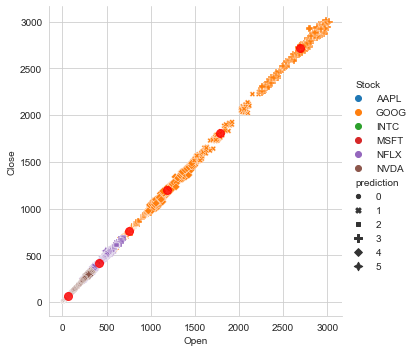

In [146]:
sns.relplot(x="Open", y="Close", hue="Stock", 
            style="prediction", 
            size="prediction",
            data=pandasDF);

plt.scatter([c[0] for c in centers], 
            [c[1] for c in centers], 
            c='red', s=64, alpha=0.8);

### 2 Clusters

In [147]:
cols = ['Open','High','Low','Close']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

kmeans = KMeans(k=2, seed=1)

pipeline = Pipeline(stages = [df_assembler, kmeans])

In [148]:
pipeline_model = pipeline.fit(model_df)

In [149]:
centers = pipeline_model.stages[-1].clusterCenters()

centers

[array([130.90819921, 132.39259159, 129.34184086, 129.15887635]),
 array([1388.11502193, 1401.48644737, 1375.6763231 , 1389.1730848 ])]

In [150]:
predictions = pipeline_model.transform(model_df)

predictions.printSchema()

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Stock: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [151]:
model_df.groupBy('Stock').count().show()

+-----+-----+
|Stock|count|
+-----+-----+
| MSFT| 2266|
| NFLX| 2266|
| INTC| 2266|
| NVDA| 2266|
| AAPL| 2266|
| GOOG| 2266|
+-----+-----+



In [152]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1368|
|         0|12228|
+----------+-----+



In [153]:
predictions.groupBy('prediction').pivot(
    'Stock').count().show()

+----------+----+----+----+----+----+----+
|prediction|AAPL|GOOG|INTC|MSFT|NFLX|NVDA|
+----------+----+----+----+----+----+----+
|         1|null|1368|null|null|null|null|
|         0|2266| 898|2266|2266|2266|2266|
+----------+----+----+----+----+----+----+



In [154]:
# Evaluate clustering by computing Silhouette score

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance =",
      str(silhouette))

Silhouette with squared euclidean distance = 0.9110617695937108


In [155]:
pandasDF = predictions.select(
    'Open','Close','Stock', 
    'prediction').toPandas()

pandasDF.head(5)

,Open,Close,Stock,prediction
0,19.78,16.96,AAPL,0
1,19.57,16.75,AAPL,0
2,19.18,16.28,AAPL,0
3,18.64,16.18,AAPL,0
4,18.90,16.23,AAPL,0


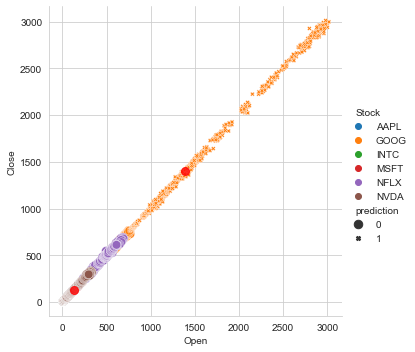

In [156]:
sns.relplot(x="Open", y="Close", hue="Stock", 
            style="prediction", 
            size="prediction",
            data=pandasDF);

plt.scatter([c[0] for c in centers], 
            [c[1] for c in centers], 
            c='red', s=64, alpha=0.8);

The silhouette score is higher for 2 clusters than it is for 6 clusters.

# Question 7

In [157]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg  import Vectors
from pyspark.ml.feature import StandardScaler

In [158]:
cols = ['Open','High','Low','Close']

vecAssembler = VectorAssembler(inputCols=cols, outputCol='features')

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")

pipeline = Pipeline(stages = [vecAssembler, scaler, pca])

In [159]:
model = pipeline.fit(stocksDF)

scaledDF = model.transform(stocksDF).select('pcaFeatures', 'Stock')

scaledDF.show(5, truncate=False)

+------------------------------------------+-----+
|pcaFeatures                               |Stock|
+------------------------------------------+-----+
|[1.0517271625635063,0.0012061703648587052]|AAPL |
|[1.0524211525936442,0.0011884149339342898]|AAPL |
|[1.0543996492189345,0.0013312379186493084]|AAPL |
|[1.0559027591589856,6.50244189941529E-4]  |AAPL |
|[1.0552054412449061,9.602883885992397E-4] |AAPL |
+------------------------------------------+-----+
only showing top 5 rows



In [160]:
model.stages[-1].explainedVariance

DenseVector([0.9999, 0.0])

In [161]:
model.stages[-1].explainedVariance.sum()

0.9999761510115195

In [162]:
from pyspark.ml.functions import vector_to_array

In [163]:
scaledDF.printSchema()

root
 |-- pcaFeatures: vector (nullable = true)
 |-- Stock: string (nullable = true)



In [164]:
pcaDF = scaledDF.withColumn(
    'PC1', vector_to_array('pcaFeatures')[0]
).withColumn(
    'PC2', vector_to_array('pcaFeatures')[1]
).select('PC1', 'PC2', 'Stock')

pcaDF.show(5)

+------------------+--------------------+-----+
|               PC1|                 PC2|Stock|
+------------------+--------------------+-----+
|1.0517271625635063|0.001206170364858...| AAPL|
|1.0524211525936442|0.001188414933934...| AAPL|
|1.0543996492189345|0.001331237918649...| AAPL|
|1.0559027591589856| 6.50244189941529E-4| AAPL|
|1.0552054412449061|9.602883885992397E-4| AAPL|
+------------------+--------------------+-----+
only showing top 5 rows



In [165]:
# for plotting
pandasDF = pcaDF.toPandas()
pandasDF.head(5)

,PC1,PC2,Stock
0,1.051727,0.001206,AAPL
1,1.052421,0.001188,AAPL
2,1.054400,0.001331,AAPL
3,1.055903,0.000650,AAPL
4,1.055205,0.000960,AAPL


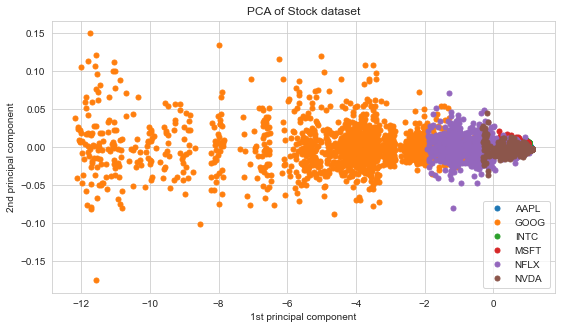

In [167]:
fig, ax = plt.subplots(figsize=(9,5))      
    
groups = pandasDF.groupby('Stock')

for name, group in groups:
    ax.plot(group['PC1'], group['PC2'], marker='o', 
             linestyle='', markersize=5, label=name)

ax.set_title('PCA of Stock dataset')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')


plt.legend();

In [168]:
cols = ['PC1','PC2']

df_assembler = VectorAssembler(
    inputCols=cols, 
    outputCol="features")

kmeans = KMeans(k=2, seed=1)

pipeline = Pipeline(stages = [df_assembler, kmeans])

In [170]:
pipeline_model = pipeline.fit(pcaDF)

In [171]:
centers = pipeline_model.stages[-1].clusterCenters()

centers

[array([ 5.59034140e-01, -7.74812939e-06]),
 array([-5.00104499e+00,  6.93137339e-05])]

In [172]:
predictions = pipeline_model.transform(pcaDF)

predictions.printSchema()

root
 |-- PC1: double (nullable = true)
 |-- PC2: double (nullable = true)
 |-- Stock: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [173]:
pcaDF.groupBy('Stock').count().show()

+-----+-----+
|Stock|count|
+-----+-----+
| MSFT| 2266|
| NFLX| 2266|
| INTC| 2266|
| NVDA| 2266|
| AAPL| 2266|
| GOOG| 2266|
+-----+-----+



In [174]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1367|
|         0|12229|
+----------+-----+



In [175]:
predictions.groupBy('prediction').pivot(
    'Stock').count().show()

+----------+----+----+----+----+----+----+
|prediction|AAPL|GOOG|INTC|MSFT|NFLX|NVDA|
+----------+----+----+----+----+----+----+
|         1|null|1367|null|null|null|null|
|         0|2266| 899|2266|2266|2266|2266|
+----------+----+----+----+----+----+----+



In [176]:
# Evaluate clustering by computing Silhouette score

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance =",
      str(silhouette))

Silhouette with squared euclidean distance = 0.9111248771219532


In [177]:
pandasDF = predictions.select(
    'PC1','PC2','Stock', 
    'prediction').toPandas()

pandasDF.head(5)

,PC1,PC2,Stock,prediction
0,1.051727,0.001206,AAPL,0
1,1.052421,0.001188,AAPL,0
2,1.054400,0.001331,AAPL,0
3,1.055903,0.000650,AAPL,0
4,1.055205,0.000960,AAPL,0


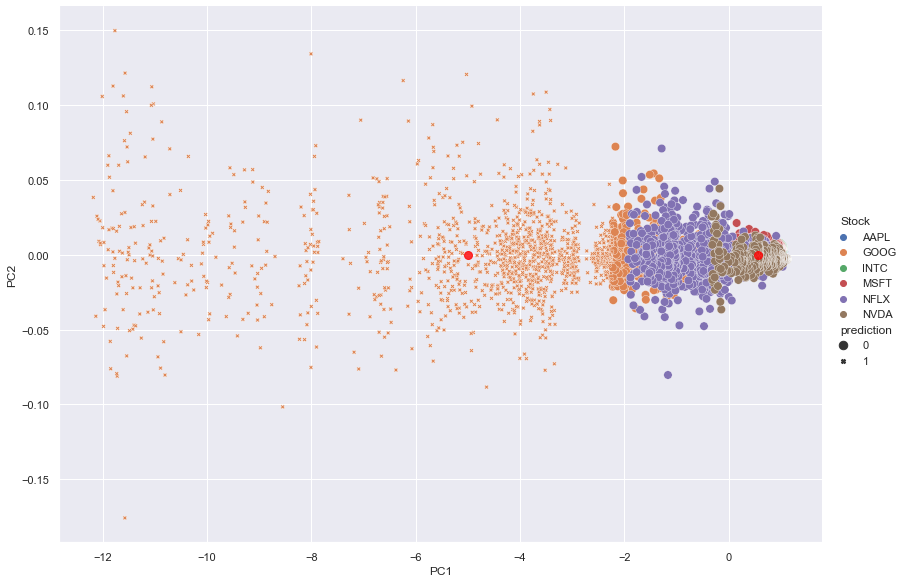

In [191]:

sns.relplot(x="PC1", y="PC2", hue="Stock", 
            style="prediction", 
            size="prediction",
            data=pandasDF,height=8.27, aspect=11.7/8.27);


plt.scatter([c[0] for c in centers], 
            [c[1] for c in centers], 
            c='red', s=64, alpha=0.8);


In [192]:
spark.stop()